In [71]:
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
from yellowbrick.model_selection import LearningCurve
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.regressor import PredictionError
# Algorithms
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Lasso
from xgboost import XGBRegressor
from sklearn.kernel_ridge import KernelRidge
# preproceessing
from model_transformers import FeaturesInteractions,SkewTransformer,ZeroThreshold

from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import train_test_split,cross_validate
from sklearn.model_selection import RepeatedKFold,GridSearchCV,KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler,MinMaxScaler

# sklearn classes
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone


In [9]:
#dataframe final
df_final = pd.read_csv("../data/DF_train15noChangeContact_skempiAB_modeller_final.csv",index_col=0)


pdb_names = df_final.index
features_names = df_final.drop('ddG_exp',axis=1).columns
df_final.shape

(1392, 78)

In [10]:
# Split train and independent test data

X_train, X_test, y_train, y_test = train_test_split(df_final.drop('ddG_exp',axis=1), df_final['ddG_exp'], 
                                                    test_size=0.2, random_state=13)     

# join train data for Exploratory analisis of training data
train = X_train.join(y_train)

# Drop outliers
train = train.drop(train[(train['van_der_waals_change']>3)].index)
train = train.drop(train[(train['dg_change'].abs()>8)].index)

y_train = train['ddG_exp']
X_train = train.drop('ddG_exp',axis=1)

In [48]:
full_data = pd.concat([X_train, X_test])
y_full = pd.concat([y_train, y_test])

# Modelling

#### Crossvalidation strategy

In [194]:
#Validation function
n_folds = 10

def evaluating(model,train,target):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    #rkf = RepeatedKFold(n_splits=10,n_repeats=10,random_state=13)
    cvscore = cross_validate(model, train, target, scoring=["r2","neg_mean_squared_error"],
                             cv = kf,verbose=1,n_jobs=-1,return_train_score=True)
    return(cvscore)

In [195]:
# preprocess pipeline steps
#steps pipeline
interactions = FeaturesInteractions(interaction1=X_train.columns[:15].tolist(),interaction2="van_der_waals_change")
skewness = SkewTransformer(threshold=0.6,method='quantile')
zeroth = ZeroThreshold(threshold=90.)

#### algorithms

In [211]:
#lasso model
lasso = make_pipeline(interactions,skewness,zeroth,MinMaxScaler(),
                      Lasso(alpha=0.001,normalize=True,fit_intercept=True,random_state=1))
# svr polynomial kernel
svrP = make_pipeline(interactions,skewness,zeroth,MinMaxScaler(),
                      SVR(C=1,degree=2,epsilon=0.4,gamma=0.5,kernel='poly'))

svrRBF = make_pipeline(interactions,skewness,zeroth,MinMaxScaler(),
                      SVR(C=2.5,epsilon=0.5,gamma=0.5,kernel='rbf'))

gbt = make_pipeline(interactions,skewness,zeroth,MinMaxScaler(),
                   GradientBoostingRegressor(n_estimators=100, learning_rate=0.05,
                                   max_depth=6, max_features='sqrt',
                                   min_samples_leaf=5, min_samples_split=2, 
                                   loss='huber', random_state =5,subsample=0.6,alpha=0.7))

xgbr = make_pipeline(interactions,skewness,zeroth,
                   XGBRegressor(colsample_bytree=0.7, gamma=3, 
                             learning_rate=0.07, max_depth=3, 
                             min_child_weight=20, n_estimators=100,
                             reg_alpha=1.9, reg_lambda=2.7,
                             subsample=0.5,random_state =7, nthread = -1))


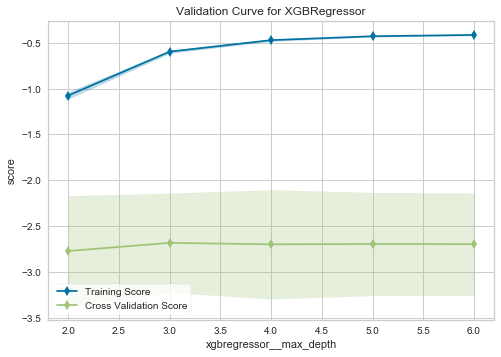

1


In [142]:
import numpy as np

from yellowbrick.model_selection import ValidationCurve

#1)
#2)
#3) Crear pipeline

viz = ValidationCurve(
    xgbr, njobs=-1,param_name="xgbregressor__max_depth",
    param_range=[2,3,4,5,6], cv=10, scoring="neg_mean_squared_error",n_jobs=-1)
#plt.ylim(0,0.6)
# Fit and poof the visualizer
viz.fit(X_train, y_train)
viz.poof()
print(viz.test_scores_mean_.argmax())

In [120]:
viz.test_scores_mean_.argmax()

2

#### Base model scores

In [204]:

score = evaluating(lasso,X_train,y_train)

print("Lasso RMSE test: {:.4f} ({:.4f})\n".format(np.sqrt(-score["test_neg_mean_squared_error"]).mean(),
                                                    np.sqrt(-score["test_neg_mean_squared_error"]).std()))
print("Lasso r2 test: {:.4f} ({:.4f})\n".format(score["test_r2"].mean(),
                                                    score["test_r2"].std()))

print('RMSE overfitt')
RMSE_diff =np.sqrt(-score["test_neg_mean_squared_error"]).mean()-np.sqrt(-score["train_neg_mean_squared_error"]).mean()
print(RMSE_diff)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Lasso RMSE test: 1.7245 (0.1926)

Lasso r2 test: 0.1451 (0.0632)

RMSE overfitt
0.04010925875432436


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.7s finished


In [210]:
score = evaluating(xgbr,X_train,y_train)

print("XGBR RMSE test: {:.4f} ({:.4f})\n".format(np.sqrt(-score["test_neg_mean_squared_error"]).mean(),
                                                    np.sqrt(-score["test_neg_mean_squared_error"]).std()))
print("XGBR r2 test: {:.4f} ({:.4f})\n".format(score["test_r2"].mean(),
                                                    score["test_r2"].std()))
print('RMSE overfitt')
RMSE_diff =np.sqrt(-score["test_neg_mean_squared_error"]).mean()-np.sqrt(-score["train_neg_mean_squared_error"]).mean()
print(RMSE_diff)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


XGBR RMSE test: 1.6298 (0.1905)

XGBR r2 test: 0.2373 (0.0505)

RMSE overfitt
0.34240634761348976


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.0s finished


In [206]:
score = evaluating(svrP,X_train,y_train)

print("SVRpoly RMSE test: {:.4f} ({:.4f})\n".format(np.sqrt(-score["test_neg_mean_squared_error"]).mean(),
                                                    np.sqrt(-score["test_neg_mean_squared_error"]).std()))
print("SVRpoly r2 test: {:.4f} ({:.4f})\n".format(score["test_r2"].mean(),
                                                    score["test_r2"].std()))
print('RMSE overfitt')
RMSE_diff =np.sqrt(-score["test_neg_mean_squared_error"]).mean()-np.sqrt(-score["train_neg_mean_squared_error"]).mean()
print(RMSE_diff)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


SVRpoly RMSE test: 1.7132 (0.1863)

SVRpoly r2 test: 0.1540 (0.0859)

RMSE overfitt
0.17010848501651843


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.9s finished


In [207]:
score = evaluating(svrRBF,X_train,y_train)

print("svrRBF RMSE test: {:.4f} ({:.4f})\n".format(np.sqrt(-score["test_neg_mean_squared_error"]).mean(),
                                                    np.sqrt(-score["test_neg_mean_squared_error"]).std()))
print("svrRBF r2 test: {:.4f} ({:.4f})\n".format(score["test_r2"].mean(),
                                                    score["test_r2"].std()))

print('RMSE overfitt')
RMSE_diff =np.sqrt(-score["test_neg_mean_squared_error"]).mean()-np.sqrt(-score["train_neg_mean_squared_error"]).mean()
print(RMSE_diff)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


svrRBF RMSE test: 1.6718 (0.1876)

svrRBF r2 test: 0.1965 (0.0544)

RMSE overfitt
0.2372212684348758


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.0s finished


In [212]:
score = evaluating(gbt,X_train,y_train)

print("GBT RMSE test: {:.4f} ({:.4f})\n".format(np.sqrt(-score["test_neg_mean_squared_error"]).mean(),
                                                    np.sqrt(-score["test_neg_mean_squared_error"]).std()))
print("GBT r2 test: {:.4f} ({:.4f})\n".format(score["test_r2"].mean(),
                                                    score["test_r2"].std()))

print('RMSE overfitt')
RMSE_diff =np.sqrt(-score["test_neg_mean_squared_error"]).mean()-np.sqrt(-score["train_neg_mean_squared_error"]).mean()
print(RMSE_diff)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


GBT RMSE test: 1.6269 (0.1888)

GBT r2 test: 0.2392 (0.0665)

RMSE overfitt
0.471997230938082


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.8s finished


In [213]:

class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)

In [215]:
averaged_models = AveragingModels(models = (gbt, svrP,xgbr,svrRBF, lasso))
score = evaluating(averaged_models,X_train,y_train)

print("AvgModels RMSE test: {:.4f} ({:.4f})\n".format(np.sqrt(-score["test_neg_mean_squared_error"]).mean(),
                                                    np.sqrt(-score["test_neg_mean_squared_error"]).std()))
print("AvgModels r2 test: {:.4f} ({:.4f})\n".format(score["test_r2"].mean(),
                                                    score["test_r2"].std()))
print('RMSE overfitt')
RMSE_diff =np.sqrt(-score["test_neg_mean_squared_error"]).mean()-np.sqrt(-score["train_neg_mean_squared_error"]).mean()
print(RMSE_diff)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


AvgModels RMSE test: 1.6437 (0.1913)

AvgModels r2 test: 0.2239 (0.0607)

RMSE overfitt
0.2535349127583433


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.7s finished


In [216]:
averaged_models.fit(X_train,y_train)
averaged_models_pred = averaged_models.predict(X_test)

In [217]:
print(np.sqrt(mean_squared_error(y_test, averaged_models_pred)))
print(r2_score(y_test,averaged_models_pred))
print(np.corrcoef(averaged_models_pred,y_test.values.ravel())[0][1])

1.6633133693470914
0.3025438502192619
0.5874654833406603


In [ ]:
gbt,svrRBF,lasso
1.6563667667638433
0.3083573471120372
0.6022405537857707

In [218]:
final_avg = averaged_models.fit(full_data,y_full)
from sklearn.externals import joblib

# save final model

joblib.dump(final_avg, 'avg_models_FINAL.pkl')

['avg_models_FINAL.pkl']

In [241]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X.iloc[train_index], y.iloc[train_index])
                y_pred = instance.predict(X.iloc[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)


In [242]:
lassoMeta = make_pipeline(MinMaxScaler(), Lasso(alpha =0.001, random_state=1,normalize=True,fit_intercept=True))
svrMeta = make_pipeline(make_pipeline(MinMaxScaler(),
                      SVR(C=1,degree=2,epsilon=0.4,gamma=0.5,kernel='poly')))

xgbMeta = make_pipeline(make_pipeline(XGBRegressor(colsample_bytree=0.7, gamma=3, 
                             learning_rate=0.07, max_depth=3, 
                             min_child_weight=20, n_estimators=100,
                             reg_alpha=1.9, reg_lambda=2.7,
                             subsample=0.5,random_state =7, nthread = -1)))

In [255]:
stacked_averaged_models = StackingAveragedModels(base_models = (gbt, svrP,svrRBF,xgbr),
                                                 meta_model = svrMeta)

In [256]:
score = evaluating(stacked_averaged_models,X_train,y_train)

print("StackedModels RMSE test: {:.4f} ({:.4f})\n".format(np.sqrt(-score["test_neg_mean_squared_error"]).mean(),
                                                    np.sqrt(-score["test_neg_mean_squared_error"]).std()))
print("StackedModels r2 test: {:.4f} ({:.4f})\n".format(score["test_r2"].mean(),
                                                    score["test_r2"].std()))

print('RMSE overfitt')
RMSE_diff =np.sqrt(-score["test_neg_mean_squared_error"]).mean()-np.sqrt(-score["train_neg_mean_squared_error"]).mean()
print(RMSE_diff)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


StackedModels RMSE test: 1.6406 (0.1825)

StackedModels r2 test: 0.2261 (0.0570)

RMSE overfitt
0.3159108305636431


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   21.3s finished


In [257]:
stacked_averaged_models.fit(X_train,y_train)

StackingAveragedModels(base_models=(Pipeline(memory=None,
     steps=[('featuresinteractions', FeaturesInteractions(interaction1=['clash', 'covalent', 'vdw_clash', 'vdw', 'proximal', 'hbond', 'weak_hbond', 'xbond', 'ionic', 'metal_complex', 'aromatic', 'hydrophobic', 'carbonyl', 'polar', 'weak_polar'],
           interact...reg_alpha=1.9, reg_lambda=2.7, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.5))])),
            meta_model=Pipeline(memory=None,
     steps=[('pipeline', Pipeline(memory=None,
     steps=[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('svr', SVR(C=1, cache_size=200, coef0=0.0, degree=2, epsilon=0.4, gamma=0.5,
  kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False))]))]),
            n_folds=5)

In [258]:
stacked_test_pred = stacked_averaged_models.predict(X_test)
np.sqrt(mean_squared_error(y_test, stacked_test_pred))

1.659415481653891

In [259]:
r2_score(y_test,stacked_test_pred)

0.30580892382209857

In [260]:
np.corrcoef(stacked_test_pred,y_test.values.ravel())[0][1]

0.587549965687095

In [261]:
full_data = pd.concat([X_train, X_test])
y_full = pd.concat([y_train, y_test])

In [262]:
final_stacked_averaged_models = stacked_averaged_models.fit(full_data,y_full)

In [263]:
from sklearn.externals import joblib

# save final model

joblib.dump(final_stacked_averaged_models, 'stacked_averaged_models_FINAL.pkl')

['stacked_averaged_models_FINAL.pkl']